# BDT uses Collin Soper Angle (Cosine Theta Star)

In [1]:
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import vector
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

import HH4b.utils as utils

In [2]:
def make_vector(events: pd.DataFrame, obj: str):
    """Create a ``vector`` object from the columns of the dataframe"""
    mstring = "PNetMass" if obj == "ak8FatJet" else "Mass"

    return vector.array(
        {
            "pt": events[f"{obj}Pt"],
            "phi": events[f"{obj}Phi"],
            "eta": events[f"{obj}Eta"],
            "M": events[f"{obj}{mstring}"],
        }
    )

## Load Dataset

In [3]:
year = "2018"  #
dir_name = "23Nov18_WSel_v9_private"
path_to_dir = f"/Users/billyli/UCSD/{dir_name}/"

In [12]:
# Load your dataset
samples = {
    "hh4b": ["GluGlutoHHto4B_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8"],
    # "hh4b-c2p45": ["GluGlutoHHto4B_cHHH2p45_TuneCP5_PSWeights_13TeV-powheg-pythia8"],
    # "hh4b-c5": ["GluGlutoHHto4B_cHHH5_TuneCP5_PSWeights_13TeV-powheg-pythia8"],
    # "hh4b-c0": ["GluGlutoHHto4B_cHHH0_TuneCP5_PSWeights_13TeV-powheg-pythia8"],
    "qcd": [
        "QCD_HT-200to300-13TeV",
        "QCD_HT-300to500-13TeV",
        "QCD_HT-500to700-13TeV",
        "QCD_HT-700to1000-13TeV",
        "QCD_HT-1000to1500-13TeV",
        "QCD_HT-1500to2000-13TeV",
        "QCD_HT-2000toInf-13TeV",
    ],
    "ttbar": [
        "TTTo2L2Nu_13TeV",
        "TTToHadronic_13TeV",
        "TTToSemiLeptonic_13TeV",
    ],
}

dirs = {path_to_dir: samples}

filters = [
    [
        # one good fatjet (fatjet with index 0 has the largest Xbb score)
        ("('ak8FatJetPt', '0')", ">=", 300),
        ("('ak8FatJetMsd', '0')", ">=", 60),
        ("('ak8FatJetPNetXbb', '0')", ">=", 0.9734),  # medium WP
        # second fatjet has lower
        ("('ak8FatJetPNetXbb', '1')", "<", 0.9880),  # tight WP
    ]
]

# columns to load
# the parquet files are too big so we can only load a few columns at a time without consumming much memory
load_columns = [
    ("weight", 1),
    ("ak8FatJetMsd", 2),
    ("ak8FatJetPNetMass", 2),
    ("ak8FatJetPNetXbb", 2),
    ("ak4JetOutside", 2),
]
# reformat into ("column name", "idx") format for reading multiindex columns
columns = []
for key, num_columns in load_columns:
    for i in range(num_columns):
        columns.append(f"('{key}', '{i}')")


events_dict = {}
for input_dir, samples in dirs.items():
    events_dict = {
        **events_dict,
        # this function will load files (only the columns selected), apply filters and compute a weight per event
        **utils.load_samples(
            input_dir, samples, year, filters=filters, load_weight_noxsec=False, reorder_txbb=False
        ),
    }

samples_loaded = list(events_dict.keys())
keys_loaded = list(events_dict[samples_loaded[0]].keys())
print("Keys in events_dict")
for i in keys_loaded:
    print(i)

Loading GluGlutoHHto4B_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8
Loaded GluGlutoHHto4B_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8: 17313 entries
Loading QCD_HT-200to300-13TeV


/Users/billyli/UCSD/HH4b/src/HH4b/utils.py:346: UserWarning: No events for QCD_HT-200to300-13TeV!
  warnings.warn(f"No events for {sample}!", stacklevel=1)


Loading QCD_HT-1000to1500-13TeV
Loaded QCD_HT-1000to1500-13TeV                           : 5063 entries
Loading QCD_HT-500to700-13TeV
Loaded QCD_HT-500to700-13TeV                             : 995 entries
Loading QCD_HT-700to1000-13TeV
Loaded QCD_HT-700to1000-13TeV                            : 6868 entries
Loading QCD_HT-300to500-13TeV
Loaded QCD_HT-300to500-13TeV                             : 3 entries
Loading QCD_HT-1500to2000-13TeV
Loaded QCD_HT-1500to2000-13TeV                           : 5878 entries
Loading QCD_HT-2000toInf-13TeV
Loaded QCD_HT-2000toInf-13TeV                            : 2349 entries
Loading TTToHadronic_13TeV
Loaded TTToHadronic_13TeV                                : 241513 entries
Loading TTToSemiLeptonic_13TeV
Loaded TTToSemiLeptonic_13TeV                            : 194522 entries
Loading TTTo2L2Nu_13TeV
Loaded TTTo2L2Nu_13TeV                                   : 28298 entries
Keys in events_dict
('ht', 0)
('nCentralJets', 0)
('nOutsideJets', 0)
('nFatJets', 

## Event cuts

In [13]:
# Higgs candidate selection example
events_raw = pd.concat(
    [events_dict["hh4b"], events_dict["qcd"], events_dict["ttbar"]], keys=["hh4b", "qcd", "ttbar"]
)

In [14]:
events_raw.keys()

MultiIndex([(           'ht',  0),
            ( 'nCentralJets',  0),
            ( 'nOutsideJets',  0),
            (     'nFatJets',  0),
            ('vbf_selection',  0),
            (  'GenHiggsEta',  0),
            (  'GenHiggsEta',  1),
            (  'GenHiggsPhi',  0),
            (  'GenHiggsPhi',  1),
            ( 'GenHiggsMass',  0),
            ...
            (       'tauPhi',  0),
            (       'tauPhi',  1),
            (      'tauMass',  0),
            (      'tauMass',  1),
            (        'tauPt',  0),
            (        'tauPt',  1),
            (       'MET_pt',  0),
            (       'weight',  0),
            ('weight_nonorm', ''),
            (  'finalWeight', '')],
           length=381)

In [15]:
# AK4OutsideJet pt cut
jets_outside_raw = make_vector(events_raw, "ak4JetOutside")
j3_raw = jets_outside_raw[:, 0]
j4_raw = jets_outside_raw[:, 1]
j3j4_pt_cut = (j3_raw.pt > 20) & (j4_raw.pt > 20)

In [16]:
combined_filter = j3j4_pt_cut
events = events_raw[combined_filter]

## Define Targets

In [17]:
events["target"] = 0  # default is background
events.loc["hh4b", "target"] = 1  # Set to 1 for 'hh4b' samples (signal)

/var/folders/lf/yggx1zv12tz2k1d1xnx1g6q00000gn/T/ipykernel_59641/3466626933.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events["target"] = 0  # default is background
/var/folders/lf/yggx1zv12tz2k1d1xnx1g6q00000gn/T/ipykernel_59641/3466626933.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  events.loc["hh4b", "target"] = 1  # Set to 1 for 'hh4b' samples (signal)


In [18]:
# define target
target = events["target"]

In [19]:
multiIndex = events.index
events = events.reset_index()

## Define Features

In [20]:
# Use pandas df as feature container
pdf = pd.DataFrame()

# H1 features
fatjets = make_vector(events, "ak8FatJet")  # fatjets sorted by xbb
h1 = fatjets[:, 0]
pdf["logPtH1"] = np.log(h1.pt)  #
pdf["hb_eta"] = h1.eta  #


# H2 features
jets_outside = make_vector(events, "ak4JetOutside")  # sorted by b-score
j3 = jets_outside[:, 0]
j4 = jets_outside[:, 1]
h2 = j3 + j4
pdf["hr_pt"] = h2.pt  #
pdf["hr_eta"] = h2.eta  #
pdf["hr_mass"] = h2.mass  #

# j3 j4 features
j3_deepJetB = events.ak4JetOutsidebtagDeepFlavB[0]
j4_deepJetB = events.ak4JetOutsidebtagDeepFlavB[1]

pn_b = events.ak4JetOutsidebtagPNetProbb + events.ak4JetOutsidebtagPNetProbbb
pn_c = events.ak4JetOutsidebtagPNetProbc + events.ak4JetOutsidebtagPNetProbcc
pn_uds = events.ak4JetOutsidebtagPNetProbuds
pn_g = events.ak4JetOutsidebtagPNetProbg
ak4JetOutsidePNetFlavB = pn_b / (pn_c + pn_uds + pn_g)
j3_PNetFlavB = ak4JetOutsidePNetFlavB[0]
j4_PNetFlavB = ak4JetOutsidePNetFlavB[1]

j3_btag = j3_PNetFlavB
j4_btag = j4_PNetFlavB

pdf["logPtJ3"] = np.log(j3.pt)  #
pdf["logPtJ4"] = np.log(j4.pt)  #
pdf["j3_btag"] = j3_btag  #
pdf["j4_btag"] = j4_btag  #

pdf["dPhiJ3J4"] = j3.deltaphi(j4)
pdf["dRJ3J4"] = j3.deltaR(j4)  #
pdf["j3_j4_ratio"] = j3.pt / j4.pt  #

# HH features
hh = h1 + h2
drh1h2 = np.sqrt((h1.eta - h2.eta) ** 2 + (h1.phi - h2.phi) ** 2)

pdf["logPtHH"] = np.log(hh.pt)  #
pdf["HHMass"] = hh.M  #
pdf["HHEta"] = hh.eta  #  #

pdf["H1Pt_H2Pt"] = h1.pt / h2.pt  #
pdf["dphi"] = h1.deltaphi(h2)  #
pdf["deta"] = h1.deltaeta(h2)  #
pdf["dRH1H2"] = drh1h2  #

# Second fatjet
fj2 = fatjets[:, 1]
pdf["fj2_pt"] = fj2.pt  #
pdf["fj2_eta"] = fj2.eta  #
pdf["fj2_mass"] = fj2.M  #

### Collins Sopper Angle

In [21]:
def calc_abs_cos_theta_star(p1, p2):
    # reference Equ (2)
    # https://terascale.physik.uni-freiburg.de/lehre/ss_14/StudentMaterial/SchleicherProc
    # calculate particles 4 vec in Collins-Soper frame
    rest_frame = -(p1 + p2)
    p1_b = p1.boost_p4(rest_frame)
    p2_b = p2.boost_p4(rest_frame)
    p1p2_b = p1_b + p2_b

    # massless
    factor1_numerator = np.abs(np.sinh(p1_b.deltaeta(p2_b)))
    factor1_denominator = np.sqrt(1 + np.square((p1p2_b.pt) / (p1p2_b.M)))
    factor1 = factor1_numerator / factor1_denominator

    factor2_numerator = 2 * p1_b.pt * p2_b.pt
    factor2_denominator = np.square(p1p2_b.M)
    factor2 = factor2_numerator / factor2_denominator

    return factor1 * factor2

In [22]:
hh_cos_theta_star = calc_abs_cos_theta_star(h1, h2)
rhbb_cos_theta_star = calc_abs_cos_theta_star(j3, j4)
pdf["hh_cos_theta_star"] = hh_cos_theta_star
pdf["rhbb_cos_theta_star"] = rhbb_cos_theta_star

In [23]:
def calc_abs_cos_theta_star2(p1, p2):
    # reference Equ (2)
    # https://terascale.physik.uni-freiburg.de/lehre/ss_14/StudentMaterial/SchleicherProc
    # calculate particles 4 vec in Collins-Soper frame
    rest_frame = -(p1 + p2)
    p1_b = p1.boost_p4(rest_frame)
    p2_b = p2.boost_p4(rest_frame)

    return np.abs(p1_b.costheta)

In [24]:
hh_cos_theta_star2 = calc_abs_cos_theta_star2(h1, h2)
rhbb_cos_theta_star2 = calc_abs_cos_theta_star2(j3, j4)
pdf["hh_cos_theta_star"] = hh_cos_theta_star
pdf["rhbb_cos_theta_star"] = rhbb_cos_theta_star

In [25]:
print(hh_cos_theta_star[0:10])
print(hh_cos_theta_star2[0:10])

[0.4461068  0.45182687 0.0175857  0.25858407 0.33144041 0.56915186
 0.58007586 0.28810331 0.61049762 0.42233591]
[0.52867319 0.48439052 0.01984752 0.30031238 0.36618489 0.79993897
 0.6138169  0.34063124 0.72872107 0.46868665]


In [26]:
# LOAD FEATURES INTO PD DF
features = df.set_index(multiIndex)

In [27]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

In [28]:
# Initialize the BDT model
bdt_model = XGBClassifier(
    n_estimators=196, max_depth=17, learning_rate=0.1, subsample=0.5, random_state=42
)

In [29]:
# Train the model
bdt_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=17, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=196, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

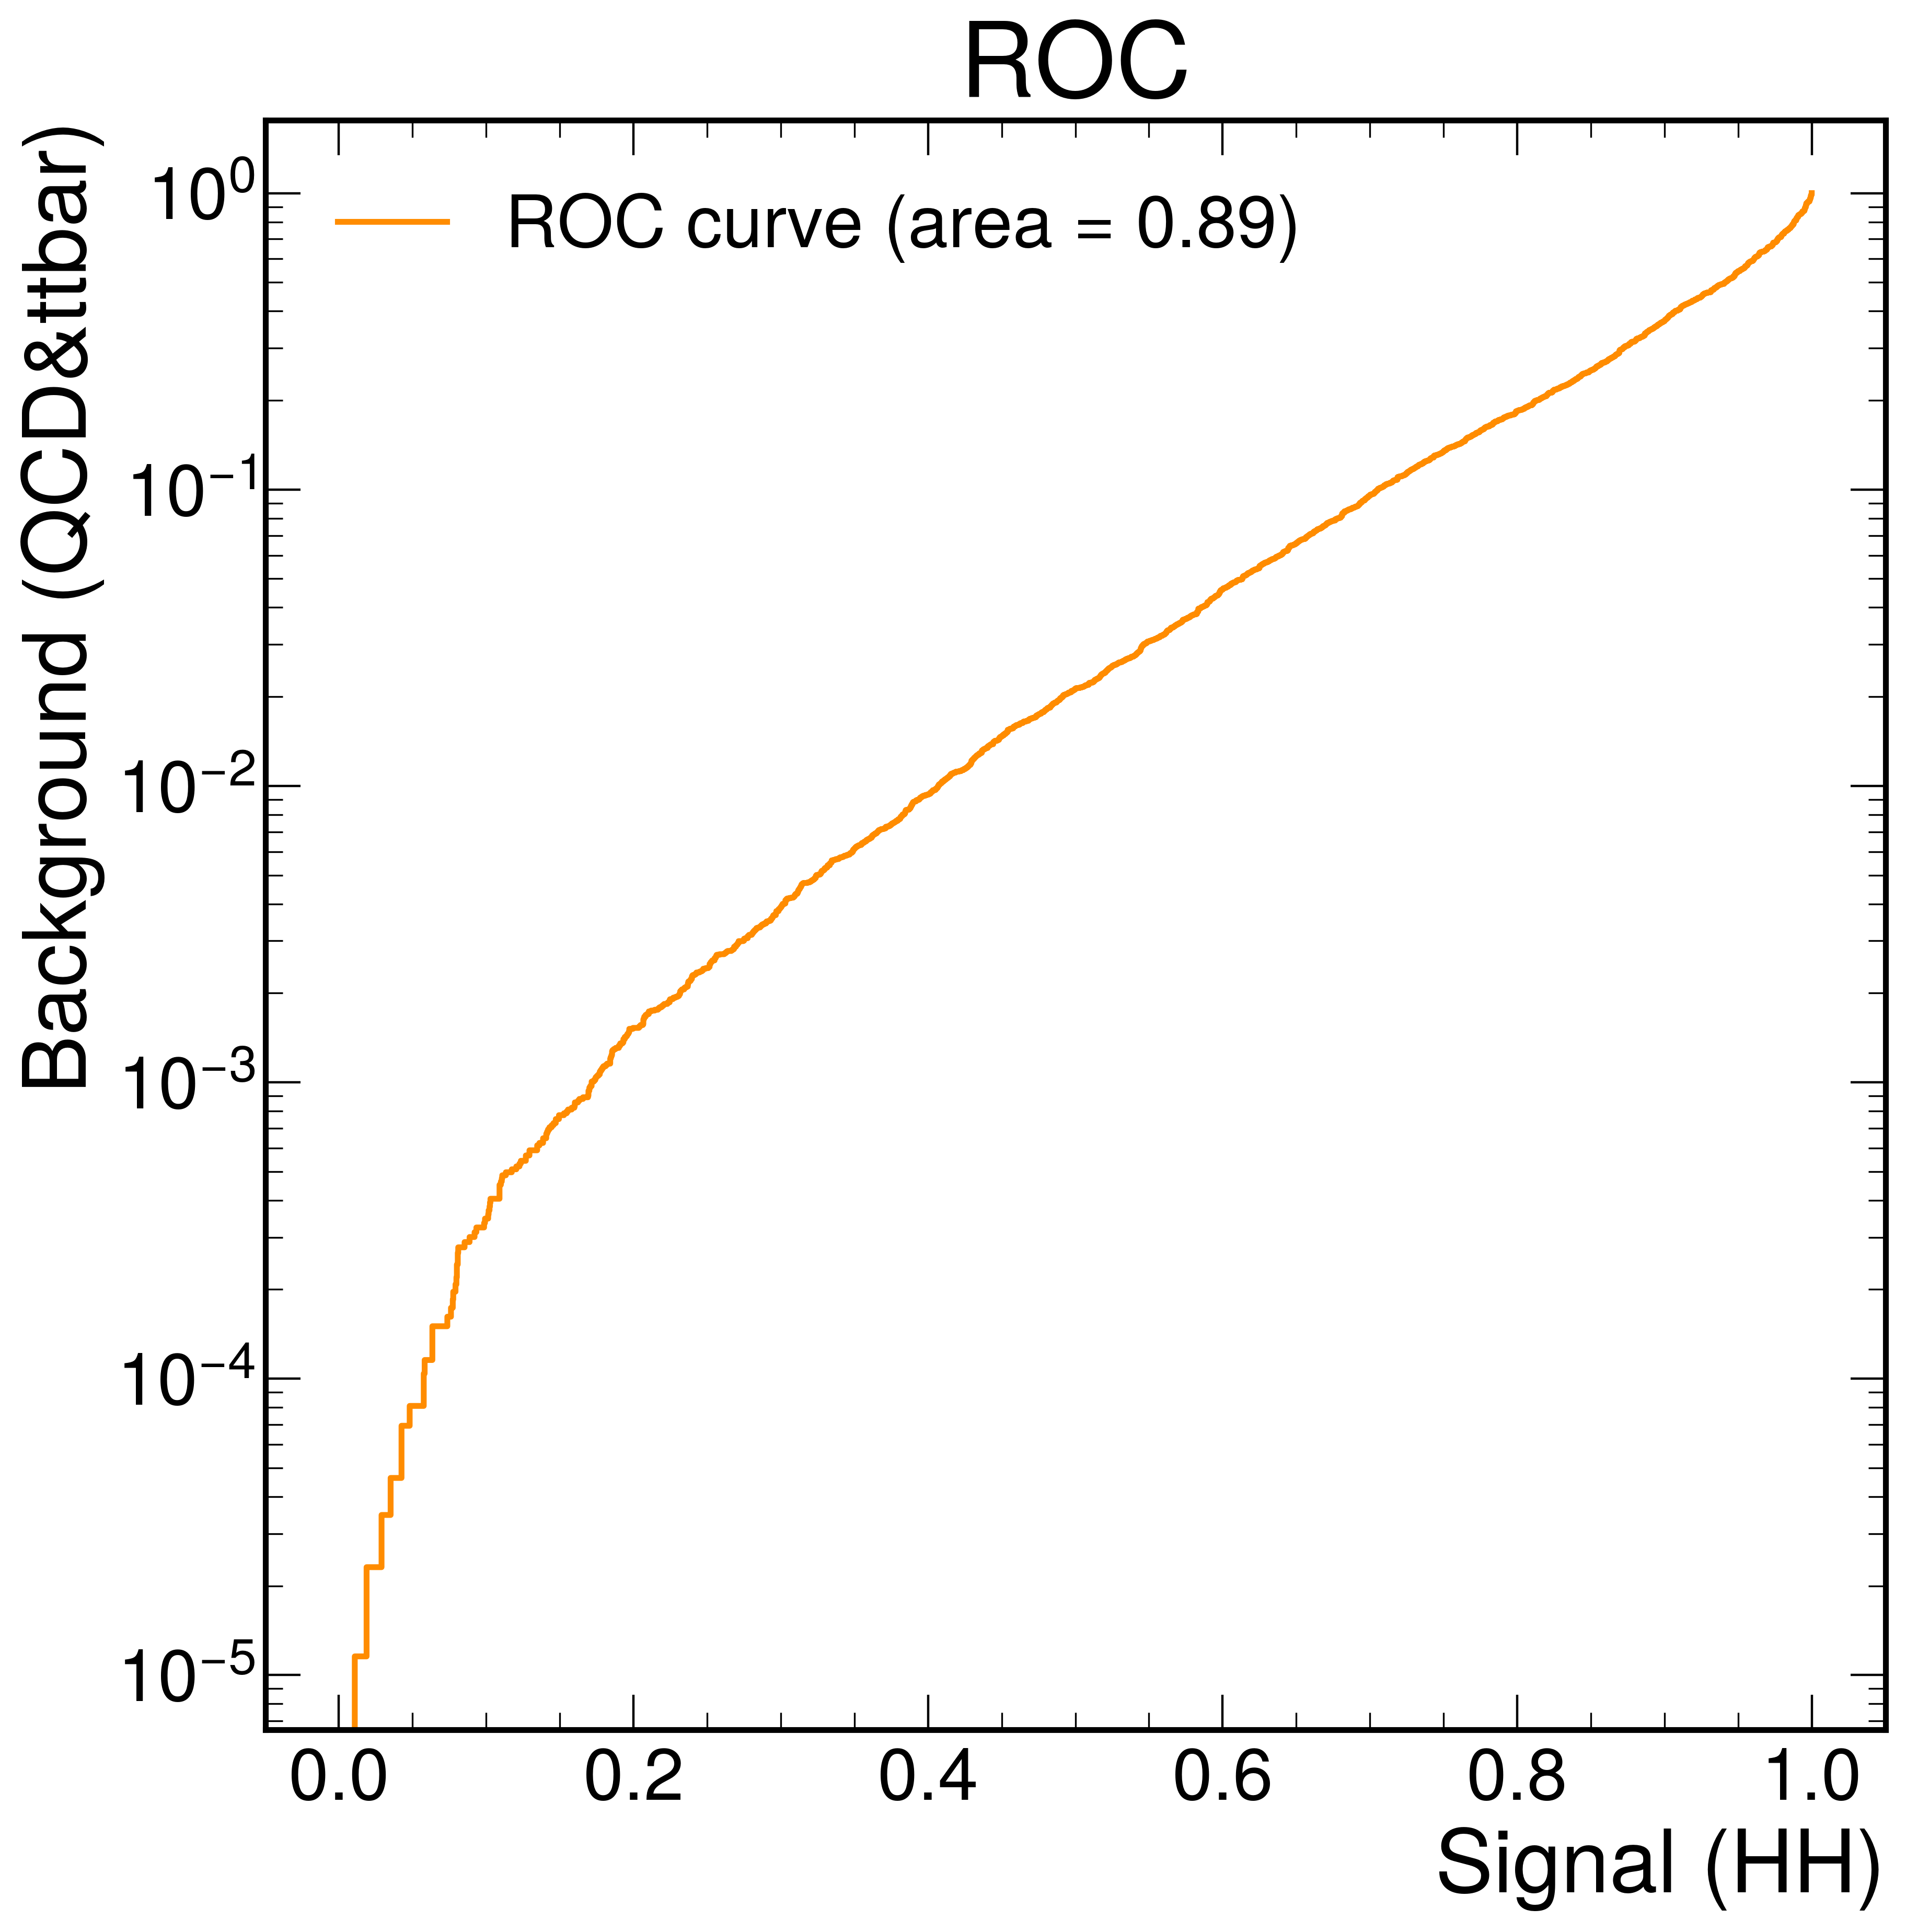

In [30]:
y_scores = bdt_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# histogram for y scores signal & background
# rank by importance

# number of b-jets that can be identified in resolved
# another feather cos(theta_star)

# Plottting
plt.figure()
plt.plot(tpr, fpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.xlabel("Signal (HH)")
plt.ylabel("Background (QCD&ttbar)")
plt.title("ROC")
plt.legend(loc="upper left")
plt.yscale("log")
plt.show()

In [31]:
print(fpr)
print(tpr)

[0.         0.         0.         ... 0.99635918 0.9963823  1.        ]
[0.00000000e+00 3.08071473e-04 1.07825015e-02 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]


In [32]:
# determine importance of the features

importances = bdt_model.feature_importances_

feature_names = df.columns
feature_importance = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

for feature in feature_importance:
    print(f"{feature[0]}: {feature[1]:.3f}")

j4_btag: 0.091
dRJ3J4: 0.081
hr_mass: 0.072
H1Pt_H2Pt: 0.054
fj2_mass: 0.049
logPtHH: 0.041
HHMass: 0.040
deta: 0.039
fj2_pt: 0.037
j3_btag: 0.037
hr_pt: 0.036
logPtJ4: 0.034
dRH1H2: 0.034
logPtJ3: 0.034
j3_j4_ratio: 0.033
logPtH1: 0.033
hh_cos_theta_star: 0.033
fj2_eta: 0.032
HHEta: 0.032
hb_eta: 0.032
rhbb_cos_theta_star: 0.032
hr_eta: 0.032
dPhiJ3J4: 0.032
dphi: 0.031


In [33]:
hh4b_scores = bdt_model.predict_proba(X_test.loc["hh4b"])[:, 1]
qcd_scores = bdt_model.predict_proba(X_test.loc["qcd"])[:, 1]
ttbar_scores = bdt_model.predict_proba(X_test.loc["ttbar"])[:, 1]

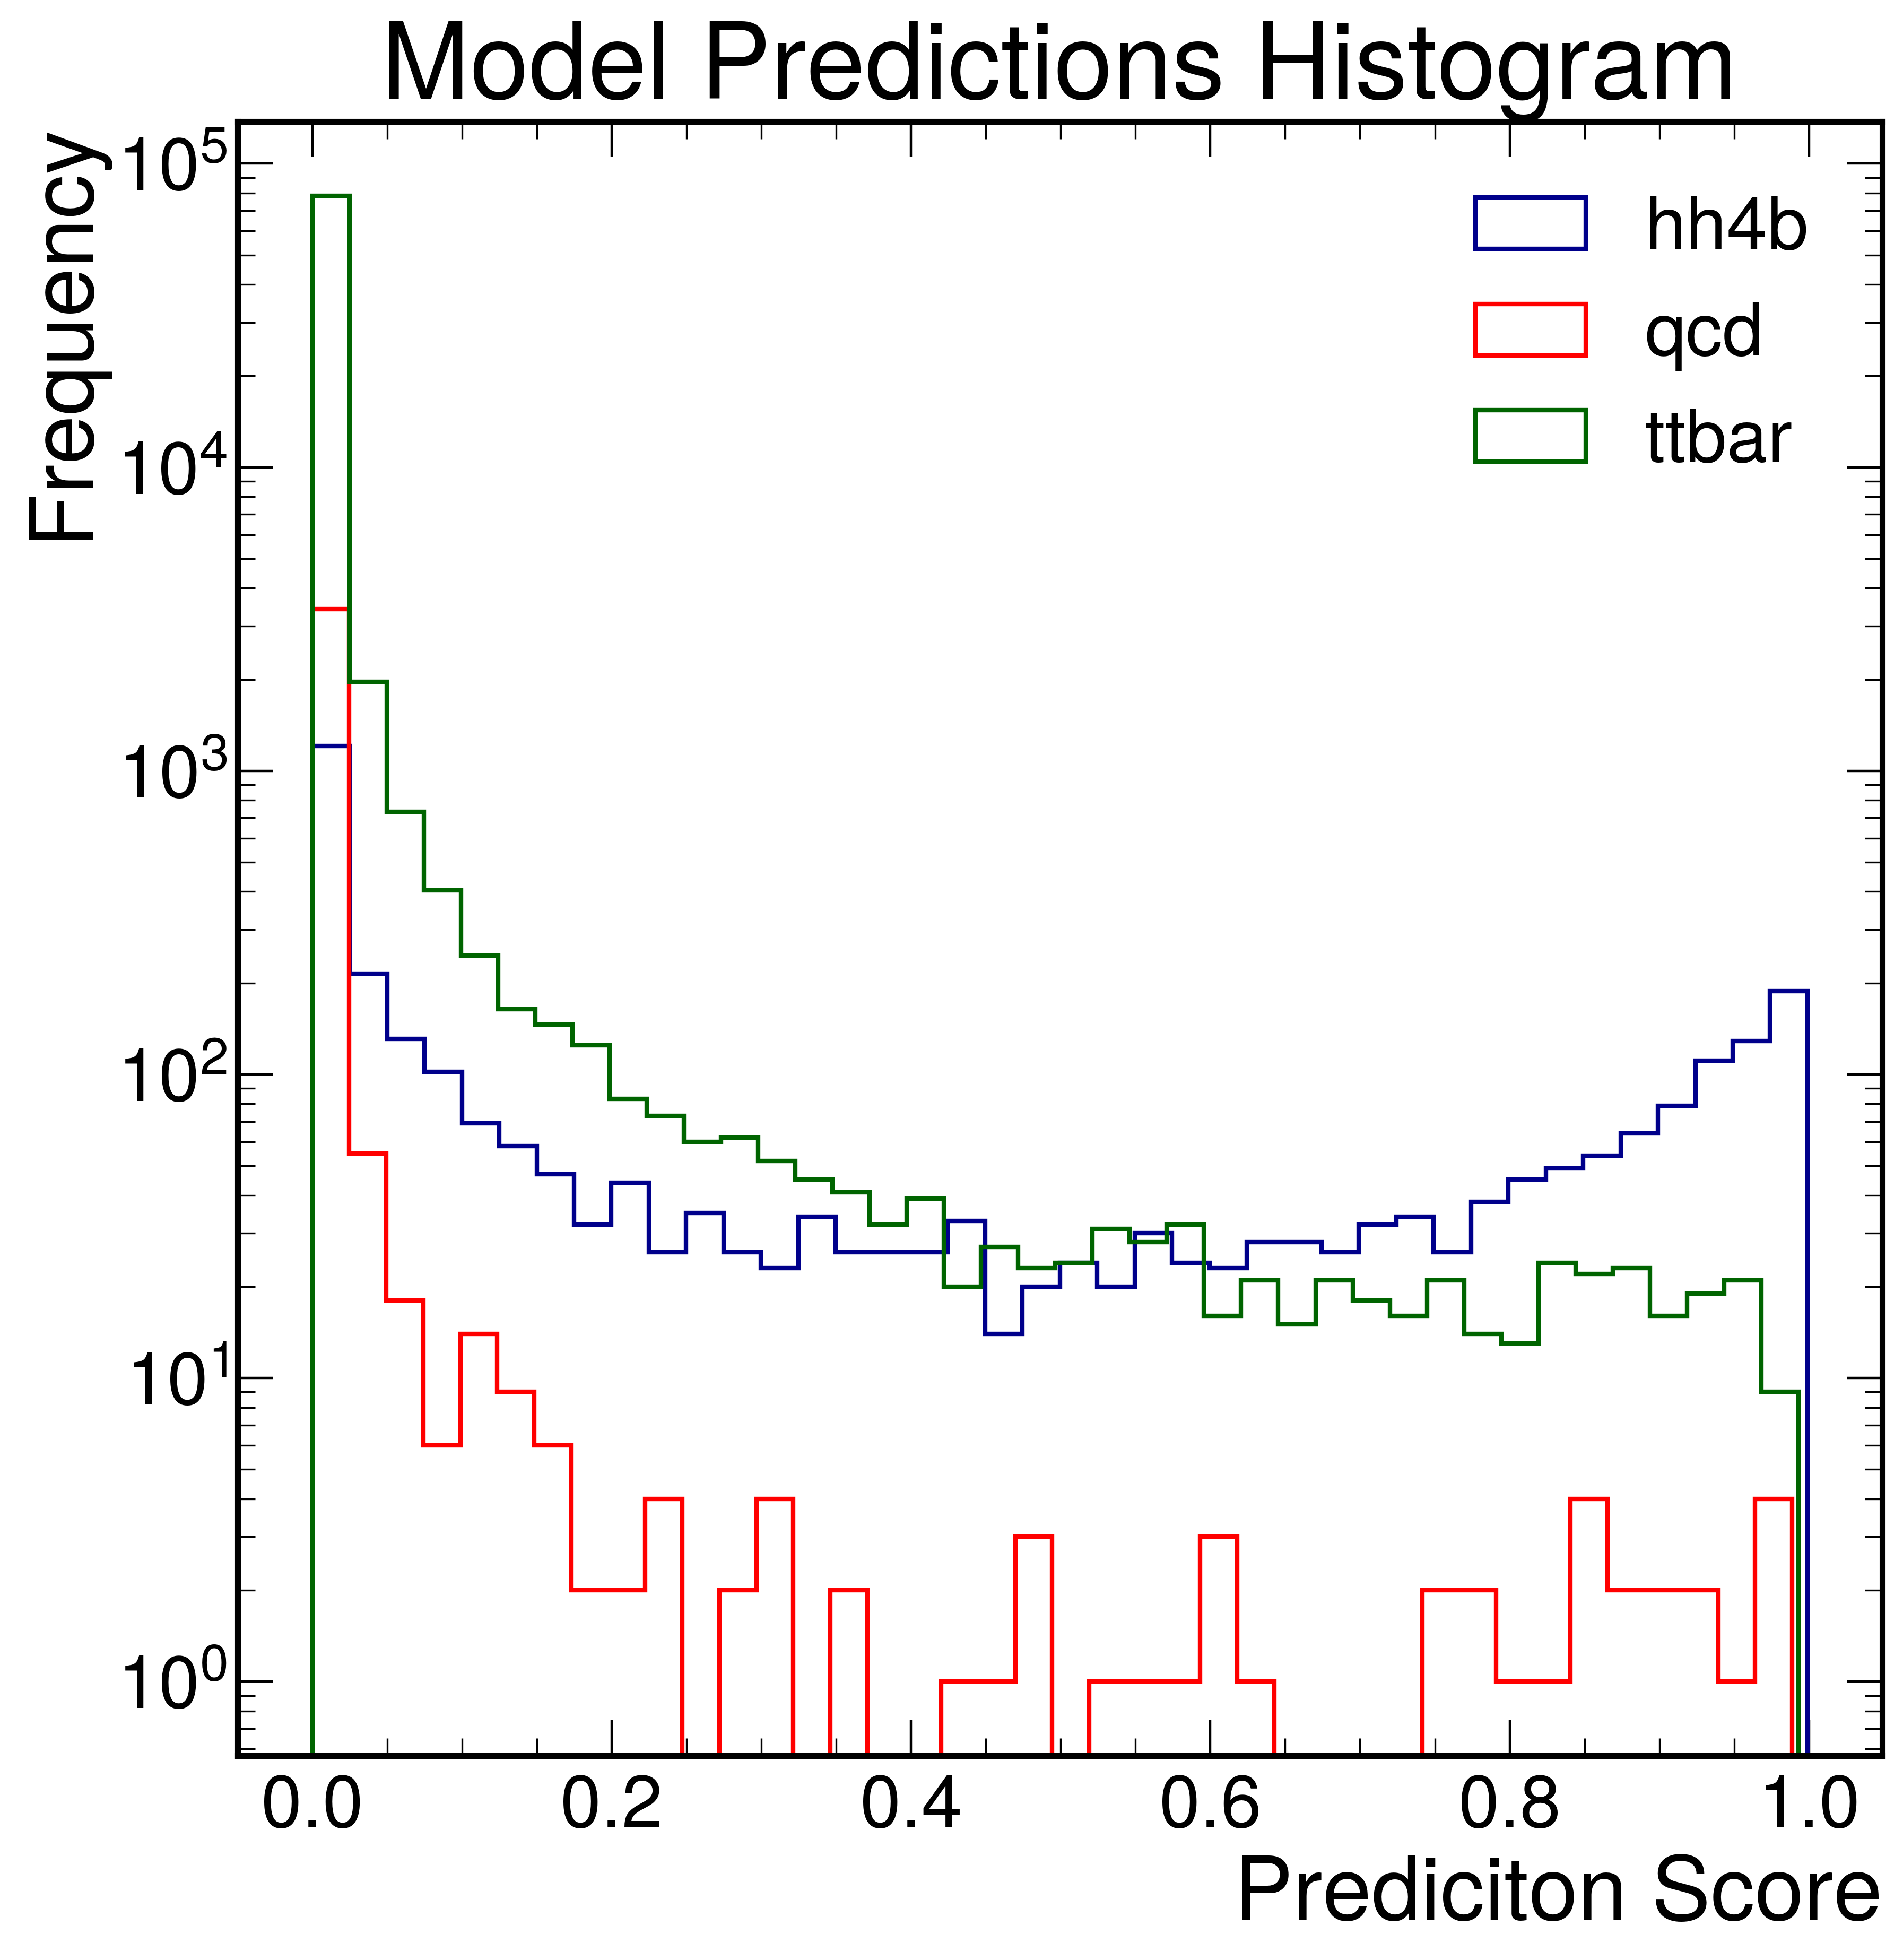

In [34]:
plt.figure()
plt.hist(hh4b_scores, bins=40, histtype="step", linewidth=1.5, color="darkblue")
plt.hist(qcd_scores, bins=40, histtype="step", linewidth=1.5, color="red")
plt.hist(ttbar_scores, bins=40, histtype="step", linewidth=1.5, color="darkgreen")
plt.legend(["hh4b", "qcd", "ttbar"])
plt.ylabel("Frequency")
plt.xlabel("Prediciton Score")
plt.title("Model Predictions Histogram")
plt.yscale("log")
plt.show()